# Home Loan Data Analysis – Course-end Project 1
**Simplilearn Deep Learning | Predict loan repayment (default)**

**Objective:** Perform data preprocessing and build a deep learning model to predict whether an applicant will repay a loan using historical data. Dataset is highly imbalanced.

In [4]:
%pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 MB 26.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 19.9 MB/s eta 0:00:00MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.9 MB/s eta 0:00:00 MB/s eta 0:00:01
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
print("TensorFlow:", tf.__version__)

TensorFlow: 2.20.0


## 1. Load Data & Data Quality
Load loan data. Target: **TARGET** (1 = repaid, 0 = default). We predict default (class 0).

In [6]:
# Load dataset (use the CSV in same folder)
df = pd.read_csv('loan_data (1).csv')
print("Shape:", df.shape)
print("Target distribution (TARGET: 1=repaid, 0=default):")
print(df['TARGET'].value_counts())
print("\\nMissing values (top 15):")
print(df.isnull().sum().sort_values(ascending=False).head(15))
df.head()

Shape: (307511, 122)
Target distribution (TARGET: 1=repaid, 0=default):
TARGET
0    282686
1     24825
Name: count, dtype: int64
\nMissing values (top 15):
COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MEDI    213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_MODE       210199
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MEDI       210199
FLOORSMIN_AVG               208642
FLOORSMIN_MODE              208642
FLOORSMIN_MEDI              208642
YEARS_BUILD_MEDI            204488
YEARS_BUILD_MODE            204488
dtype: int64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Data Preprocessing
Drop ID, drop columns with too many missing values, fill remaining, encode categoricals, and prepare numeric features.

In [10]:
# Drop identifier
if 'SK_ID_CURR' in df.columns:
    df = df.drop(columns=['SK_ID_CURR'])
# Sample for faster training (optional: use full data by removing .sample)
df_work = df.sample(n=min(50000, len(df)), random_state=42)
y = df_work['TARGET']
X_raw = df_work.drop(columns=['TARGET'])
# Drop columns with >50% missing
thresh = len(X_raw) * 0.5
X_clean = X_raw.dropna(axis=1, thresh=thresh)
print("Columns kept after dropping >50% missing:", X_clean.shape[1])
# Separate numeric and categorical
numeric_cols = X_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_clean.select_dtypes(include=['object']).columns.tolist()
print("Numeric:", len(numeric_cols), "| Categorical:", len(cat_cols))

Columns kept after dropping >50% missing: 79
Numeric: 66 | Categorical: 13


In [12]:
# Fill missing: numeric with median, categorical with mode
X_processed = X_clean.copy()
for c in numeric_cols:
    if c in X_processed.columns and X_processed[c].isnull().any():
        X_processed[c] = X_processed[c].fillna(X_processed[c].median())
for c in cat_cols:
    if c in X_processed.columns:
        X_processed[c] = X_processed[c].fillna(X_processed[c].mode().iloc[0] if len(X_processed[c].mode()) > 0 else 'Unknown')
# Label-encode categoricals
for c in cat_cols:
    if c in X_processed.columns:
        X_processed[c] = LabelEncoder().fit_transform(X_processed[c].astype(str))
# Use only numeric + encoded categoricals (all numeric now)
X_final = X_processed.select_dtypes(include=[np.number])
print("Final feature matrix shape:", X_final.shape)
print("Remaining missing:", X_final.isnull().sum().sum())

Final feature matrix shape: (50000, 79)
Remaining missing: 0


## 3. Train/Test Split, Scale, SMOTE
Stratified split, standardize features, and apply SMOTE on training set only to handle class imbalance.

In [15]:
# Drop any remaining rows with NaN
mask = ~X_final.isnull().any(axis=1)
X_final = X_final.loc[mask]
y = y.loc[mask]
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
# SMOTE on training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train_s, y_train)
print("After SMOTE - train labels:", pd.Series(y_train_bal).value_counts().to_dict())

After SMOTE - train labels: {0: 36782, 1: 36782}


## 4. Deep Learning Model
Build a feedforward neural network with Dense layers, Dropout, and early stopping.

In [18]:
n_features = X_train_bal.shape[1]
model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,233 (28.25 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train with early stopping
early = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
history = model.fit(X_train_bal, y_train_bal, validation_split=0.2, epochs=30, batch_size=256, callbacks=[early], verbose=1)

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6692 - loss: 0.6034 - val_accuracy: 0.5439 - val_loss: 0.7520
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.7148 - loss: 0.5550 - val_accuracy: 0.5800 - val_loss: 0.7164
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.7227 - loss: 0.5412 - val_accuracy: 0.5836 - val_loss: 0.7132
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7309 - loss: 0.5301 - val_accuracy: 0.6084 - val_loss: 0.6928
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7381 - loss: 0.5215 - val_accuracy: 0.6068 - val_loss: 0.6968
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.7454 - loss: 0.5122 - val_accuracy: 0.6186 - val_loss: 0.6898
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.7530 - loss: 0.5032 - val_accuracy: 0.6482 - val_loss: 0.6475
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7560 - loss: 0.4964 - va

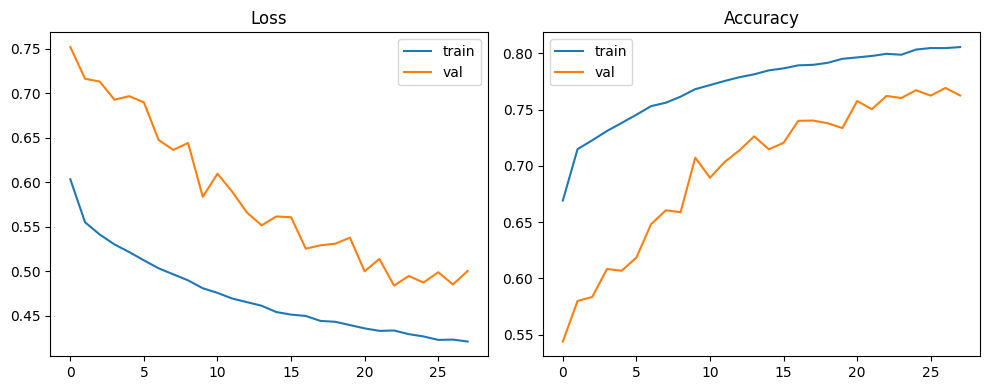

In [21]:
# Training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

## 5. Evaluation on Test Set
Evaluate on original (unbalanced) test set using accuracy, precision, recall, F1, ROC-AUC.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
Accuracy: 0.821
Precision: 0.1804
Recall: 0.3453
F1-Score: 0.237
ROC-AUC: 0.6789
\nClassification Report:
              precision    recall  f1-score   support

     Default       0.94      0.86      0.90      9195
      Repaid       0.18      0.35      0.24       805

    accuracy                           0.82     10000
   macro avg       0.56      0.60      0.57     10000
weighted avg       0.88      0.82      0.85     10000

Confusion Matrix:
[[7932 1263]
 [ 527  278]]


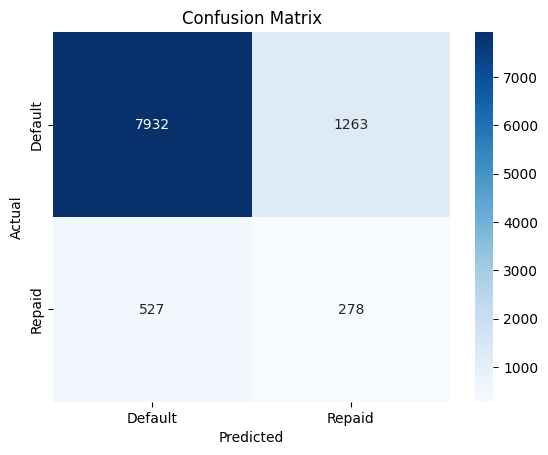

In [25]:
y_pred_proba = model.predict(X_test_s)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, y_pred, zero_division=0), 4))
print("F1-Score:", round(f1_score(y_test, y_pred, zero_division=0), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_pred_proba), 4))
print("\\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Default', 'Repaid']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Default', 'Repaid'], yticklabels=['Default', 'Repaid'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()